feature: thumb, index, middle, ring, little

length: 64

shape : $N_{sample} \times 64 \times 5$

| layer | shape | result | Activate |
| --- | --- | --- | --- |
| Input | $N_{sample} \times 5 \times 64$ |  | |
| Conv1D_1 | $F \times K$ | $N_{sample} \times F \times 64$ | Relu | 
| MaxPool | $2$ | $N_{sample} \times F \times 32$ |  |
| Conv1D_2 | $2F \times K$ | $N_{sample} \times 2F \times 32$ | Relu |
| MaxPool | $2$ | $N_{sample} \times 2F \times 16$ | |
| FC | $N_{class} \times 32F$ | $N_{sample} \times N_{class}$ | Sigmoid |
| SoftMax |  | $N_{sample} \times N_{class}$ | |



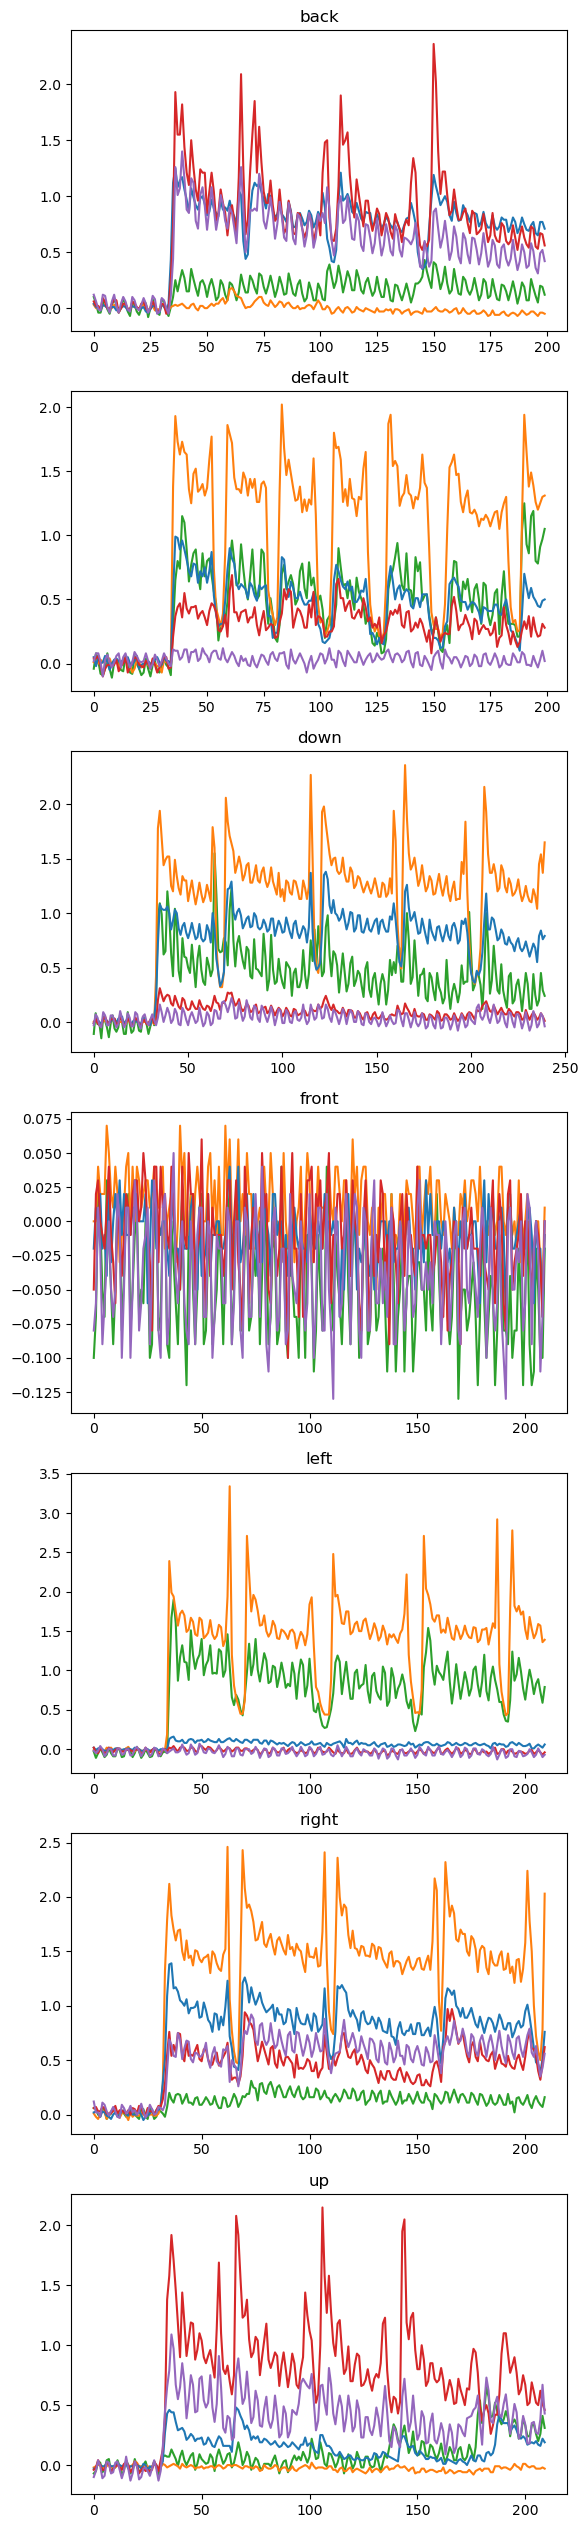

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 


fig, subplots = plt.subplots(nrows=7)
directions = (
    'back',
    'default',
    'down',
    'front',
    'left',
    'right',
    'up'
)
fig.set_figheight(32)
plt.plot()

ds = list(os.walk('Dataset'))
for i in range(0, 7):
    subplots[i].set_title(directions[i])

    dir, _, file = ds[i + 1]
    print()
    csv = os.path.join(dir, file[0])
    df = pd.read_csv(csv)
    subplots[i].plot(df['time'], df['thumb'], 'tab:green')
    subplots[i].plot(df['time'], df['index'], 'tab:orange')
    subplots[i].plot(df['time'], df['middle'], 'tab:blue')
    subplots[i].plot(df['time'], df['ring'], 'tab:red')
    subplots[i].plot(df['time'], df['little'], 'tab:purple')
    


IndexError: list index out of range

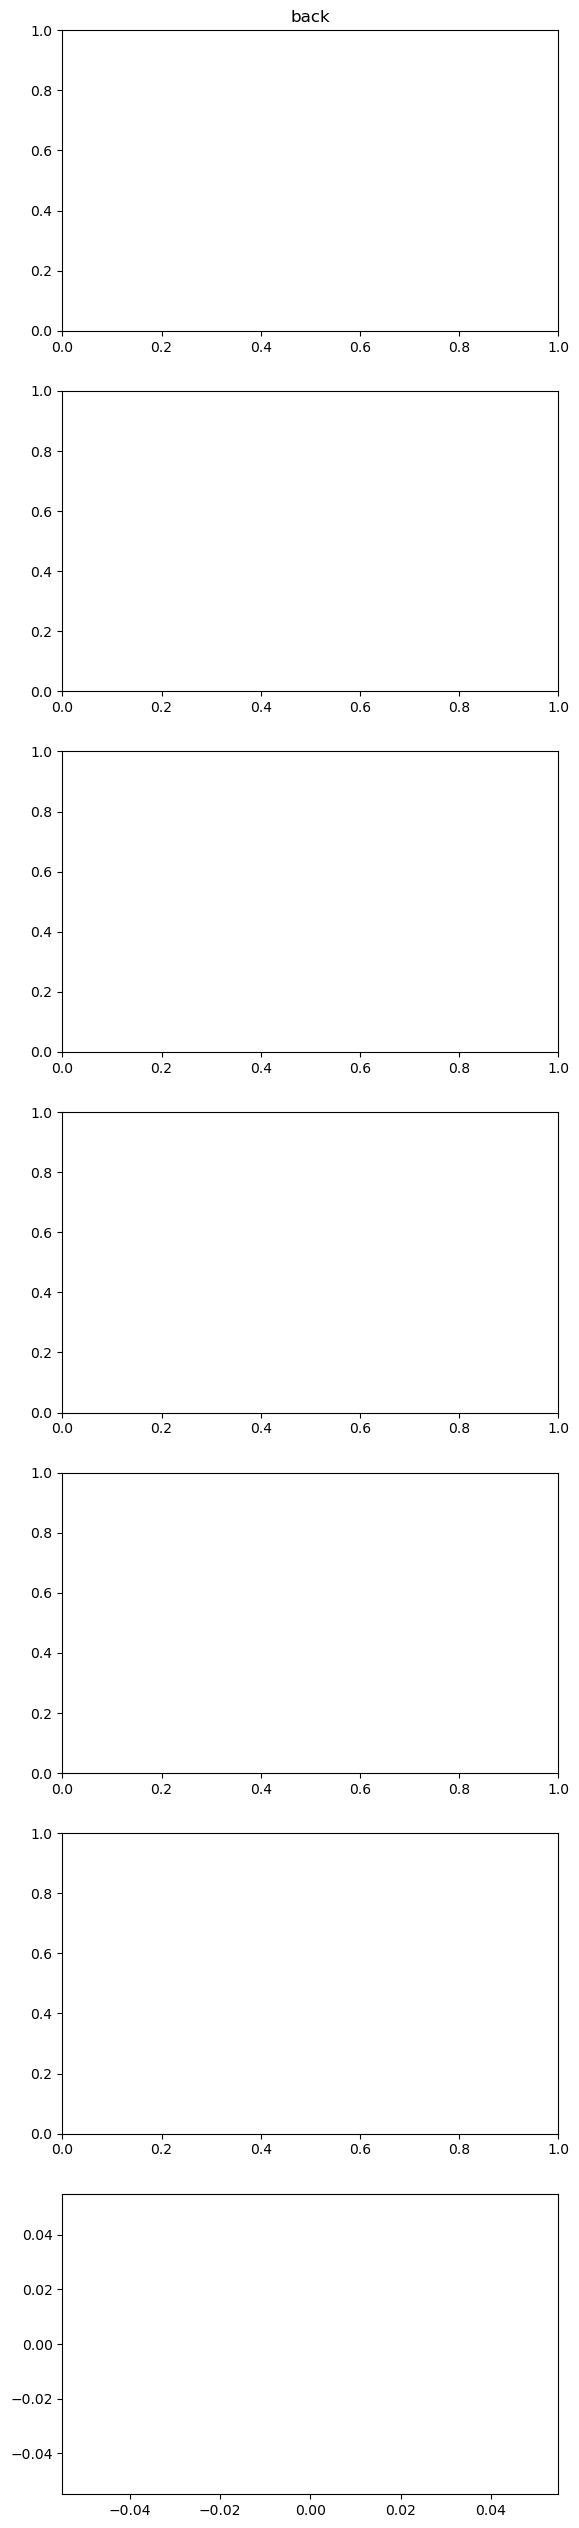

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 


fig, subplots = plt.subplots(nrows=7)
directions = (
    'back',
    'default',
    'down',
    'front',
    'left',
    'right',
    'up'
)
fig.set_figheight(32)
plt.plot()

ds = list(os.walk('version2'))
for i in range(0, 7):
    subplots[i].set_title(directions[i])

    dir, _, file = ds[i + 1]
    print()
    arr = pd.DataFrame(['thumb', 'index', 'middle', 'ring', 'little', 'class'])
    for name in file:
        df = pd.read_csv(os.path.join(dir, name))
        
        
    csv = os.path.join(dir, file[0])
    df = pd.read_csv(csv)
    subplots[i].plot(df['time'], df['thumb'], 'tab:green')
    subplots[i].plot(df['time'], df['index'], 'tab:orange')
    subplots[i].plot(df['time'], df['middle'], 'tab:blue')
    subplots[i].plot(df['time'], df['ring'], 'tab:red')
    subplots[i].plot(df['time'], df['little'], 'tab:purple')

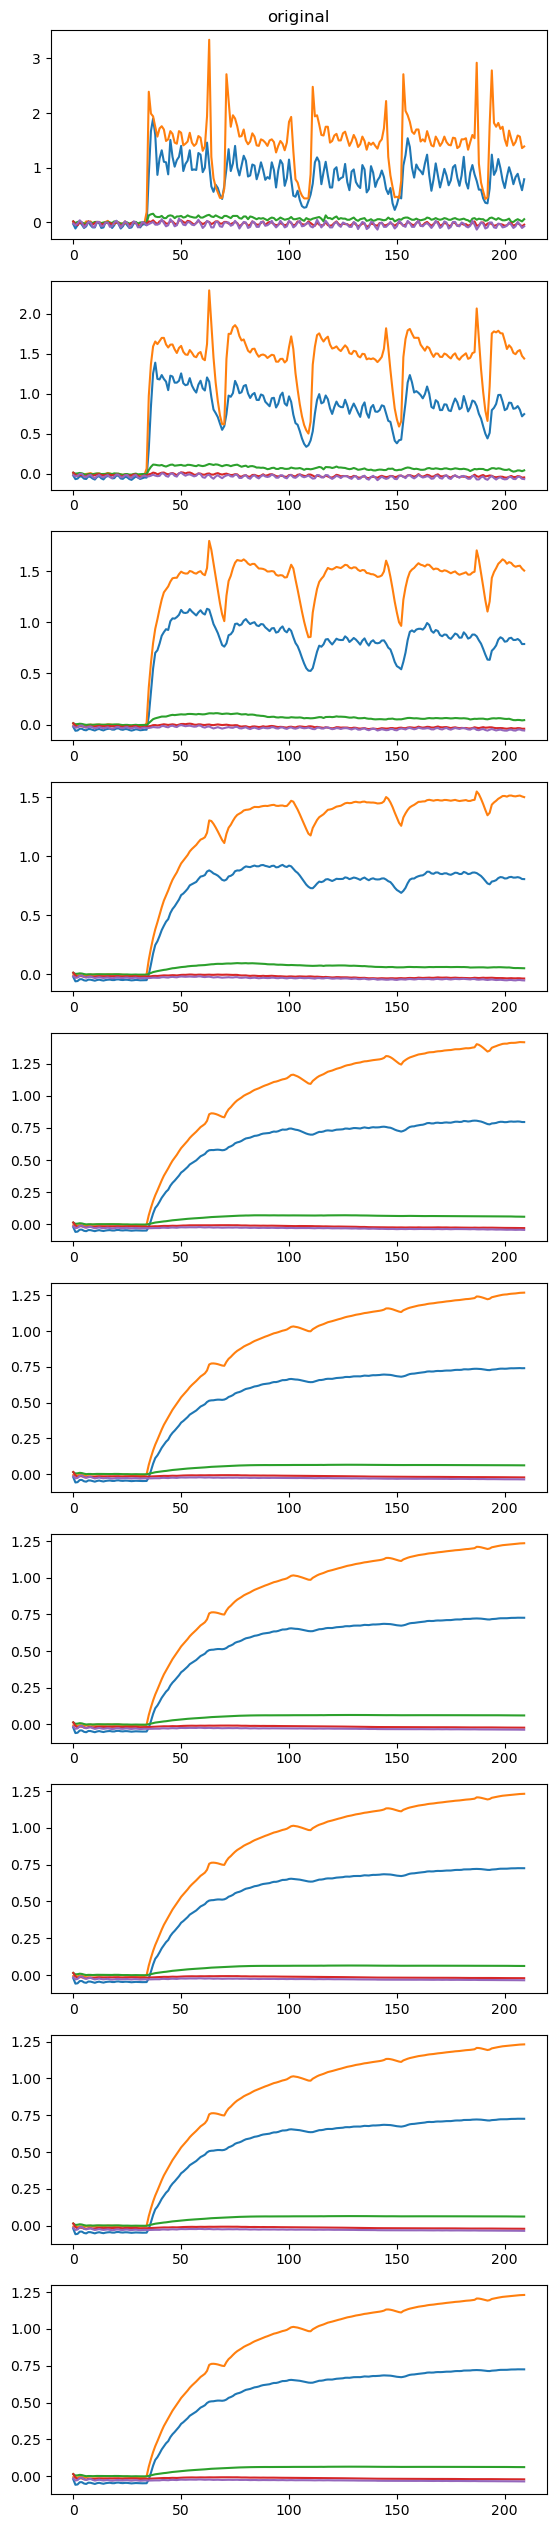

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
A = np.asarray([1] * 5)
H = np.asarray([1] * 5)
Q = np.asarray([0.01] * 5)
R = np.asarray([4] * 5)

def update(z_meas, x_esti, P):
    x_pred = A * x_esti
    P_pred = (A **2) * P + Q

    K = P_pred * H / ((H ** 2) * P_pred + R)
    x_esti = x_pred + K * (z_meas - H * x_pred)

    P = P_pred - K * H * P_pred

    return x_esti, P

dir, _, file = list(os.walk('Dataset'))[5]
csv = os.path.join(dir, file[0])
df = pd.read_csv(csv)[['thumb', 'index', 'middle', 'ring', 'little']].to_numpy()

def KalmanFilter():
    x_k = 0
    P_k = 10
    filtered = []
    for z in df:
        x_k, P_k = update(z, x_k, P_k)
        filtered += [x_k]
    return filtered

fig, subplots = plt.subplots(nrows=10)
fig.set_figheight(32)
subplots[0].set_title('original')
subplots[0].plot(df)

for idx, q in enumerate(10.0 ** np.arange(0, -9, -1)):
    Q = np.asarray([q]* 5)
    subplots[idx+1].plot(KalmanFilter())

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

class2num = {'back': 0, 'default': 1, 'down': 2, 'front': 3, 'left': 4, 'right': 5, 'up': 6}
im = np.eye(7)
print(im.shape)

class MyDataset(Dataset):
    def __init__(self, path: str = 'Dataset', frame_length: int = 32):
        # 파일 이름 배열
        self.filenames = []
        # 파일 카테고리
        self.category = []
        # 학습 데이터
        self.data = np.ndarray([0, frame_length, 5])
        # 타겟 라벨
        self.label = np.ndarray([0, 7])
        # 파일 경로 로딩
        for dirname, _, filenames in os.walk(path):
            if len(filenames) == 0: continue

            _, category = os.path.split(dirname)
            self.filenames += [os.path.join(dirname, filename) for filename in filenames]
            self.category += [category] * len(filenames)
        
        # csv 로딩
        for idx, file in enumerate(self.filenames):

            # (file_frame_length, 6)
            frame = pd.read_csv(file)

            # (file_frame_length, 5)
            frame = frame[['thumb', 'index', 'middle', 'ring', 'little']].to_numpy()

            # (file_frame_length + 50 > 160, 5)
            # frame[file_frame_length - 1] 값으로 패딩
            frame = np.pad(frame, ((0, 200), (0, 0)), mode='edge')
            
            batch = []
            for i in range(40, 168 - frame_length):
                batch += [frame[i: i + frame_length]]
                # batch += [frame[i + 32: i: -1]]
            # TODO: 프레임 1마다 한 주기씩 만들기
            # (128 / frame_length, frame_length, 5)
            batch = np.asarray(batch)
            # (total_file * 128 / frame_length, frame_length, 5)
            # print(batch.shape)
            self.data = np.append(self.data, batch, axis=0)
            
            # (total_file * 128 / frame_length, 6)
            self.label = np.append(self.label, [im[class2num[self.category[idx]]]] * len(batch), axis=0)

        print(self.data.shape, self.label.shape)

        # 정규화
        mean = self.data.mean(axis=0)
        std = self.data.std(axis=0)
        
        self.data = (self.data - mean) / std

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

(7, 7)


In [2]:
import torch.nn as nn
import torch
from torch.nn import Module, Sequential

class MyModel(Module):
    def __init__(self, filter_size: int = 8, frame_length: int = 8):
        super(MyModel, self).__init__()

        self.layer_1 = Sequential(*[
            nn.Conv1d(5, filter_size, 3, padding=1),
            nn.BatchNorm1d(filter_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
        ])

        self.layer_2 = Sequential(*[
            nn.Conv1d(filter_size, 2 * filter_size, 3, padding=1),
            nn.BatchNorm1d(2 * filter_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
        ])

        self.fc = Sequential(*[
            nn.Flatten(),
            nn.Linear(int((frame_length * filter_size) / 2), 7),
            nn.Sigmoid(),
            nn.Softmax(dim=1)
        ])

        self.drop = nn.Dropout()

    def forward(self, input: torch.FloatTensor):
        out_1 = self.layer_1(input.transpose(1, 2))
        out_2 = self.layer_2(
            self.drop(out_1) if self.training else out_1
        )
        return self.fc(out_2)

In [3]:
from torch.utils.data import DataLoader, random_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torcheval.metrics.classification.recall import MulticlassRecall
from torcheval.metrics.classification.accuracy import MulticlassAccuracy
from torcheval.metrics.classification.precision import MulticlassPrecision
from torcheval.metrics.classification.f1_score import MulticlassF1Score
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch.onnx as onnx
# import seaborn as sn

def train(epoch: int = 3000, frame_length: int = 32, filter_size: int = 8, path: str = 'Dataset'):
    with torch.device('cuda' if torch.cuda.is_available() else 'cpu') as device:

        model = MyModel(filter_size=filter_size, frame_length=frame_length).to(device)
        loss_fn = CrossEntropyLoss().to(device)
        optimizer = Adam(model.parameters())
        writer = SummaryWriter(f'runs/model_{frame_length}_{filter_size}')

        dataset = MyDataset(path=path, frame_length=frame_length)
        dataset_length = len(dataset)
        train_length = int(dataset_length * 0.8)
        test_length = int(dataset_length * 0.1)
        valid_length = dataset_length - train_length - test_length
        train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_length, test_length, valid_length], generator=torch.Generator(device))
        
        train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True, generator=torch.Generator(device))
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, generator=torch.Generator(device))
        valid_loader = DataLoader(validation_dataset, batch_size=256, shuffle=True, generator=torch.Generator(device))

        print(train_length)
        print(test_length)
        print(valid_length)

        accuracy_ = MulticlassAccuracy(num_classes=7, average=None, device=device)
        recall_ = MulticlassRecall(num_classes=7, average=None, device=device)
        precision_ = MulticlassPrecision(num_classes=7, average=None, device=device)
        f1_score_ =  MulticlassF1Score(num_classes=7, average=None, device=device)

        for step in tqdm(range(0, epoch)):
            for ((train_data, train_label), (vaild_data, valid_label)) in zip(train_loader, valid_loader):
                # print(train_data.get_device())
                model.train(True)
                optimizer.zero_grad()
                train_output = model(train_data)
                loss = loss_fn(train_output, train_label)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    model.train(False)
                    valid_output = model(vaild_data)
                    valid_loss = loss_fn(valid_output, valid_label)
                    pred = valid_output.argmax(dim=1)
                    target = valid_label.argmax(dim=1)
                    accuracy = torch.sum(pred == target) / pred.shape[0]
                    
                    if step % 25:
                        writer.add_scalar(tag='train_loss', scalar_value=loss, global_step=step)
                        writer.add_scalar(tag='valid_loss', scalar_value=valid_loss, global_step=step)
                        writer.add_scalar(tag='accuracy', scalar_value=accuracy, global_step=step)
                        accuracy_compute = accuracy_.reset().update(pred, target).compute()
                        recall_compute = recall_.reset().update(pred, target).compute()
                        f1_score_compute = f1_score_.reset().update(pred, target).compute()

                        writer.add_scalars(main_tag='accuracy_class', tag_scalar_dict={key: accuracy_compute[val] for (key, val) in class2num.items()}, global_step=step)
                        writer.add_scalars(main_tag='recall', tag_scalar_dict={key: recall_compute[val] for (key, val) in class2num.items()}, global_step=step)
                        writer.add_scalars(main_tag='f1_score', tag_scalar_dict={key: f1_score_compute[val] for (key, val) in class2num.items()}, global_step=step)

        model.train(False)
        accuracy_.reset()
        recall_.reset()
        f1_score_.reset()
        for (test_data, test_label) in test_loader:
            with torch.no_grad():
                test_data = test_data.to(device)
                test_label = test_label.to(device)
                test_output = model(test_data)
                valid_loss = loss_fn(test_output, test_label)
                pred = test_output.argmax(dim=1)
                target = test_label.argmax(dim=1)
                
                accuracy_compute = accuracy_.update(pred, target).compute()
                recall_compute = recall_.update(pred, target).compute()
                f1_score_compute = f1_score_.update(pred, target).compute()
        writer.add_scalars(main_tag='accuracy_test', tag_scalar_dict={key: accuracy_compute[val] for (key, val) in class2num.items()}, global_step=step)
        writer.add_scalars(main_tag='recall_test', tag_scalar_dict={key: recall_compute[val] for (key, val) in class2num.items()}, global_step=step)
        writer.add_scalars(main_tag='f1_score_test', tag_scalar_dict={key: f1_score_compute[val] for (key, val) in class2num.items()}, global_step=step)

        onnx.export(
            model=model,
            args=torch.randn(size=[10, frame_length, 5], device=device),
            f=f'classifier_{frame_length}_{filter_size}.onnx',
            export_params=True,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size'},
                'output': {0: 'batch_size'}
            }
        )



In [ ]:
for filter_size in [4, 8, 16, 32]:
    for frame_length in [8, 16, 32, 64]:
        train(frame_length=frame_length, filter_size=filter_size)

In [6]:
train(3000, 8, 8)

(8400, 8, 5) (8400, 7)
6720
840
840


100%|██████████| 2000/2000 [06:35<00:00,  5.05it/s]
